In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from os.path import join
#
from EPR.density_estimation import NIW, mixture
from EPR.utils import struct, ellipse

### Semi-supervised Gaussian Mixture Models

### Reproduce demo-results from the paper: 
## _Towards semi-supervised and probabilistic classification in structural health monitoring_

* Semi-supervised Gaussian Mixture Models (MAP), for density estimation and classification, implemented in Python.
* Link to the [MSSP paper](https://www.sciencedirect.com/science/article/pii/S088832702030039X).

To illustrate the potential increase in classification performance through semi-supervised model updates.

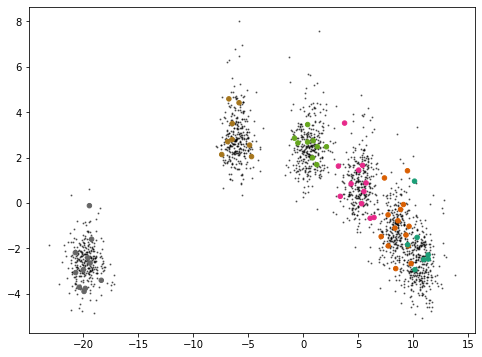

In [2]:
# import data
data = scipy.io.loadmat(join('data', '8dof_6class.mat'))
X = data['x']
Y = data['y']
Xt = data['x_test']
Yt = data['y_test']

N = X.shape[0] # no. of training data
# 3% training data
il = np.random.choice(N, int(.03*N), replace=False) # labelled idxs
iu = np.setdiff1d(range(N), il) # unlabelled idxs
# labelled data
Xl = X[il, :]
Yl = Y[il, :]
# unlabelled data
Xu = X[iu, :]
# plot
plt.figure(1, figsize=[8, 6])
plt.scatter(Xu[:,0], Xu[:,1], s=1, c='k', alpha=.5)
plt.scatter(Xl[:,0], Xl[:,1], c=Yl, s=20, cmap='Dark2')
plt.show()

### Conventional supervised learning
(blue ellipse indicates the prior)

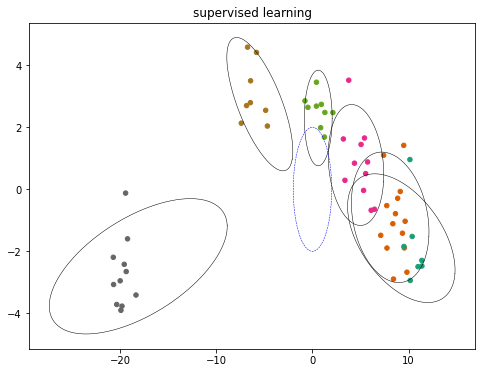

accuracy: 84.5%


In [3]:
D = 2
K = len(np.unique(Yl))
prior = struct()

prior.alpha = 1

prior.m0 = np.zeros(D)
prior.k0 = 1
prior.S0 = np.eye(D)
prior.v0 = D

GMM = mixture(K, NIW, prior)
GMM.train_supervised(Xl, Yl)

plt.figure(2, figsize=[8,6])
plt.scatter(Xl[:,0], Xl[:,1], c=Yl, s=20, cmap='Dark2')
for k  in range(K):
    e = ellipse(GMM.base[k].mu_map, GMM.base[k].Sig_map).cov_3
    plt.plot(e[1][:,0], e[1][:,1], 'k', lw=.5) # map cluster

p = ellipse(prior.m0, prior.S0).cov_3
plt.plot(p[1][:,0], p[1][:,1], 'b--', lw=.5)
plt.title('supervised learning')
pth = join('figures', 'supervised_learning.png')
# plt.savefig(pth)
plt.show()

# predict
Ypred = np.argmax(GMM.predict(Xt), 1) + 1
acc1 = np.sum(Ypred == np.squeeze(Yt))/len(Ypred) * 100
print('accuracy: ' + '%.1f' % acc1 + '%')

### Semi-supervised learning
(note the reduced effect of the prior)

log-joint-likelihood:-13777.2709
log-joint-likelihood:-13775.9290
log-joint-likelihood:-13775.5475
log-joint-likelihood:-13775.4246
log-joint-likelihood:-13775.3823
log-joint-likelihood:-13775.3671
log-joint-likelihood:-13775.3614
log-joint-likelihood:-13775.3592
log-joint-likelihood:-13775.3584
log-joint-likelihood:-13775.3580
log-joint-likelihood:-13775.3579
log-joint-likelihood:-13775.3578
log-joint-likelihood:-13775.3578


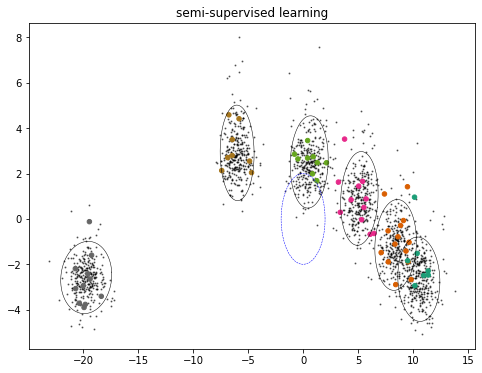

accuracy: 96.5%
accuracy increase: 11.9%


In [4]:
GMM = mixture(K, NIW, prior)
GMM.semisupervisedEM(X, Y, Xu)

plt.figure(2, figsize=[8,6])
plt.scatter(Xu[:,0], Xu[:,1], s=1, c='k', alpha=.5)
plt.scatter(Xl[:,0], Xl[:,1], c=Yl, s=20, cmap='Dark2')

for k  in range(K):
    e = ellipse(GMM.base[k].mu_map, GMM.base[k].Sig_map).cov_3
    plt.plot(e[1][:,0], e[1][:,1], 'k', lw=.5) # map cluster
    
plt.plot(p[1][:,0], p[1][:,1], 'b--', lw=.5)
plt.title('semi-supervised learning')
pth = join('figures', 'semi-supervised_learning.png')
# plt.savefig(pth)
plt.show()

# predict
Ypred = np.argmax(GMM.predict(Xt), 1) + 1
acc2 = np.sum(Ypred == np.squeeze(Yt))/len(Ypred) * 100
print('accuracy: ' + '%.1f' % acc2 + '%')

# increase
print('accuracy increase: ' + '%.1f' % (acc2-acc1) + '%')